<a href="https://colab.research.google.com/github/rolench/Magnanelli-MarineDebrisClassification-project/blob/main/Copia_di_Image_Deblurring_June_Exam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Deblurring - June Exam

Image Deblurring - June Exam Task

The task consists in creating a deblurring deep learning model, aimed to remove gaussian blur and gaussian noise from images.

You will need to create a model which, taken a blurred image X, is able to reconstruct the original deblurred image y.

Dataset

The dataset is built starting from CIFAR-10 images collection, we created a notebook(save the file linked as .ipynb) to perform the creation of the dataset without you downloading it. Do not modify the function, but feel free to further split the data to build a validation set, if needed.

The split into different data split is left to you, perform it as you like, making sure it is meaningful.

Structure

Write a notebook explaining every step you take in the building of the pipeline and DON'T clear the output of the cells when you submit it.

Make sure to test the model in order to prove robustness and lack of overfitting.

The metric you will need to use to evaluate the results is the MSE.

Hints and requirements

There are different strategies to remove such noise from images, feel free to use the one you consider to be the most appropriate, keeping in mind that the blurring is Gaussian and so is the noise.

The metrics will be evaluated on the reconstructed images, so provide a way to check the results on a batch composed of original images and reconstructed images.

You can't use ANY pre-trained models for this exam and try to build models with less than 10 milions trainable parameters.

Try to remember all the instructions we provided in the last lab lesson about the submission, make sure to output the metrics of your final model and use the adequate strategy for the task.

Save the weights of your model and keep them until the discussion, we might ask you to provide them.

### Dataset creation - DO NOT MODIFY

In [1]:
import tensorflow as tf 
import random
from cv2 import GaussianBlur
import numpy as np

def getDataset():
  (x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()
  normalize = lambda x: x/x.max()
  x_train = normalize(x_train)
  x_test = normalize(x_test)
  createBlurred = lambda arr: np.array([GaussianBlur(x, (5,5), ((random.random()*3)+1)) + (0.02*np.random.normal(0,1, (32, 32, 3))) for x in arr])
  return (createBlurred(x_train), x_train), (createBlurred(x_test), x_test)

In [2]:
(X_train, y_train), (X_test, y_test) = getDataset()

170508288/170498071 [==============================] - 2s 0us/step


In [3]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Algebra
import numpy as np

# Visualization
import matplotlib.pyplot as plt
from PIL import Image

In [4]:
X_train.shape

(50000, 32, 32, 3)

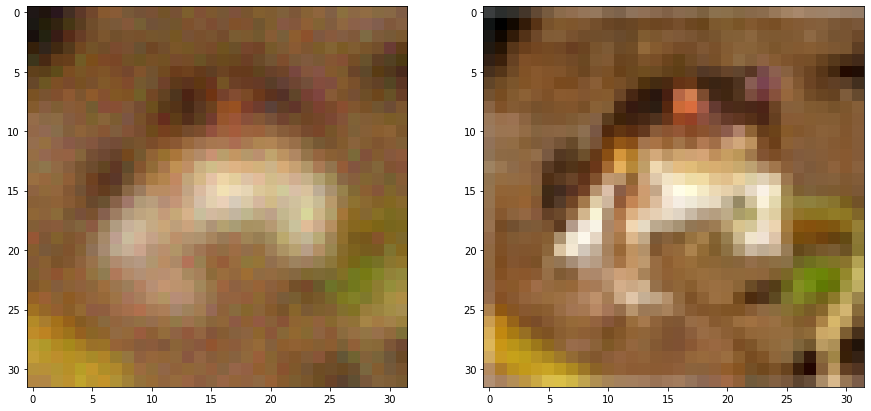

In [5]:
def show(x, y, title=None):
    plt.figure(figsize=(15, 8))

    plt.subplot(1, 2, 1)
    plt.imshow(x)
    if title:
        plt.title(title[0])
    
    plt.subplot(1, 2, 2)
    plt.imshow(y)
    if title:
        plt.title(title[1])

    plt.show()

show(X_train[0], y_train[0])

In [6]:
x_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
x_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

# y_train = y_train.reshape((len(y_train), np.prod(y_train.shape[1:])))
# y_test = y_test.reshape((len(y_test), np.prod(y_test.shape[1:])))

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(50000, 3072) (10000, 3072) (50000, 32, 32, 3) (10000, 32, 32, 3)


In [7]:
# # size of our encoded representations
# encoding_dim = 16 
# mid_dim = 64
latent_dim = 16
shape = X_train.shape[1:]

# # input placeholder
# input_img = layers.Input(shape=(shape,))
# # "encoded" is the encoded representation of the input
# encoded = layers.Dense(mid_dim, activation='relu')(input_img)
# encoded = layers.Dense(encoding_dim, activation='relu')(encoded)
# # "decoded" is the lossy reconstruction of the input
# decoded = layers.Dense(mid_dim, activation='relu')(encoded)
# decoded = layers.Dense(shape, activation='sigmoid')(decoded)

# # this model maps an input to its reconstruction
# autoencoder = Model(input_img, decoded)

def build_encoder(input_shape, n_ch, L=3):
    x = layers.Input(shape=input_shape)

    h = x
    for i in range(L):
        h = layers.Conv2D(n_ch, kernel_size=3, strides=2, padding='same')(h)
        h = layers.ReLU()(h)

        n_ch = 2*n_ch
    f = layers.Flatten()(h)
    y = layers.Dense(latent_dim)(f)
    return Model(x, y)
  
encoder = build_encoder(shape, 4, L=3)

In [8]:
# autoencoder.summary()
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 4)         112       
                                                                 
 re_lu (ReLU)                (None, 16, 16, 4)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 8)           296       
                                                                 
 re_lu_1 (ReLU)              (None, 8, 8, 8)           0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 16)          1168      
                                                                 
 re_lu_2 (ReLU)              (None, 4, 4, 16)          0     

In [9]:
def build_decoder(shape, latent_dim, n_ch, L=3):
    x = layers.Input(shape=latent_dim)
    d = layers.Dense(shape[0]*shape[1]*shape[2])(x)
    r = layers.Reshape((shape[0], shape[1], shape[2]))(d)

    h = r
    for i in range(L-1):
        h = layers.Conv2DTranspose(n_ch, kernel_size=3, strides=2, padding='same')(h)
        h = layers.ReLU()(h)

        n_ch = 2*n_ch
    y = layers.Conv2DTranspose(3, kernel_size=3, strides=2, activation='sigmoid', padding='same')(h)
    return Model(x, y)

decoder = build_decoder((4, 4, 16), latent_dim, 16)

In [10]:
decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 16)]              0         
                                                                 
 dense_1 (Dense)             (None, 256)               4352      
                                                                 
 reshape (Reshape)           (None, 4, 4, 16)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 16)         2320      
 nspose)                                                         
                                                                 
 re_lu_3 (ReLU)              (None, 8, 8, 16)          0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 32)       4640      
 ranspose)                                                 

In [11]:
autoencoder = Model(inputs=encoder.input, outputs=decoder(encoder.output), name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 4)         112       
                                                                 
 re_lu (ReLU)                (None, 16, 16, 4)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 8)           296       
                                                                 
 re_lu_1 (ReLU)              (None, 8, 8, 8)           0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 16)          1168      
                                                                 
 re_lu_2 (ReLU)              (None, 4, 4, 16)          

In [12]:
adam = Adam(learning_rate=0.001)
autoencoder.compile(optimizer=adam, loss=tf.keras.losses.MeanSquaredError(), metrics=['accuracy'])

In [20]:
check2 = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, mode='min')
history = autoencoder.fit(X_train, y_train, batch_size=128, epochs=100, validation_split=0.2)

Epoch 1/100
313/313 [==============================] - 3s 8ms/step - loss: 0.0174 - accuracy: 0.6054 - val_loss: 0.0171 - val_accuracy: 0.6065
Epoch 2/100
313/313 [==============================] - 3s 9ms/step - loss: 0.0172 - accuracy: 0.6058 - val_loss: 0.0171 - val_accuracy: 0.5919
Epoch 3/100
313/313 [==============================] - 4s 12ms/step - loss: 0.0172 - accuracy: 0.6046 - val_loss: 0.0171 - val_accuracy: 0.6068
Epoch 4/100
313/313 [==============================] - 2s 7ms/step - loss: 0.0172 - accuracy: 0.6047 - val_loss: 0.0171 - val_accuracy: 0.5959
Epoch 5/100
313/313 [==============================] - 2s 7ms/step - loss: 0.0172 - accuracy: 0.6044 - val_loss: 0.0171 - val_accuracy: 0.6124
Epoch 6/100
313/313 [==============================] - 2s 7ms/step - loss: 0.0172 - accuracy: 0.6045 - val_loss: 0.0171 - val_accuracy: 0.6008
Epoch 7/100
313/313 [==============================] - 2s 7ms/step - loss: 0.0172 - accuracy: 0.6047 - val_loss: 0.0171 - val_accuracy: 0.607

In [13]:
# We can also use the history (that we saved before) to check the behavior of the training.
# history is a Python dictionary that cointains the values of the behavior of the loss
# during training (one value for each epoch).
def display_history(history):
    mse_training = history.history['loss']
    acc_training = history.history['accuracy']

    mse_val = history.history['val_loss']
    acc_val = history.history['val_accuracy']

    # Visualize the behavior of the loss
    plt.plot(mse_training)
    plt.plot(mse_val)
    plt.grid()
    plt.title('Loss during training')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.show()

    # and of the accuracy
    plt.plot(acc_training)
    plt.plot(acc_val)
    plt.grid()
    plt.title('Accuracy during training')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.show()

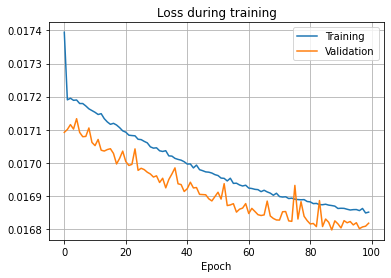

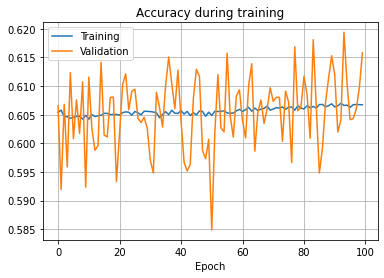

In [22]:
display_history(history)

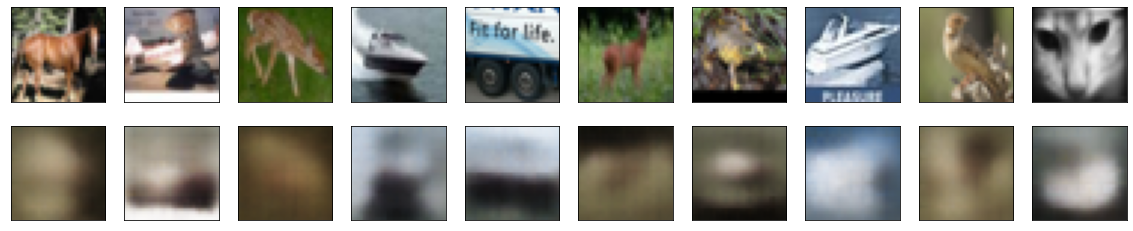

In [24]:
import matplotlib.pyplot as plt

deblurred_imgs = autoencoder.predict(X_test)

n = 10 #no images to plot
imgs = np.random.randint(low=0,high=10000,size=n)
plt.figure(figsize=(20, 4))
for (i,idx) in enumerate(imgs):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(y_test[idx])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(deblurred_imgs[idx])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [19]:
img_size = shape

def get_model(img_size):
    inputs = layers.Input(shape=img_size)

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(img_size[-1], 3, activation="sigmoid", padding='same')(x)

    # Define the model
    model = Model(inputs, outputs)
    return model

# Build model
model = get_model(img_size)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_12 (Conv2D)             (None, 16, 16, 32)   896         ['input_4[0][0]']                
                                                                                                  
 batch_normalization_15 (BatchN  (None, 16, 16, 32)  128         ['conv2d_12[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_15 (Activation)     (None, 16, 16, 32)   0           ['batch_normalization_15[0]

In [20]:
model.compile(optimizer="adam", loss=tf.keras.losses.MeanSquaredError(), metrics=['accuracy'])

In [21]:
BATCH_SIZE = 128
N_EPOCHS = 100

hist = model.fit(X_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=N_EPOCHS,
              validation_split=0.1)

Epoch 1/100
352/352 [==============================] - 16s 38ms/step - loss: 0.0324 - accuracy: 0.5981 - val_loss: 0.0508 - val_accuracy: 0.5332
Epoch 2/100
352/352 [==============================] - 11s 32ms/step - loss: 0.0133 - accuracy: 0.6836 - val_loss: 0.0122 - val_accuracy: 0.6974
Epoch 3/100
352/352 [==============================] - 12s 33ms/step - loss: 0.0112 - accuracy: 0.7038 - val_loss: 0.0110 - val_accuracy: 0.7210
Epoch 4/100
352/352 [==============================] - 12s 33ms/step - loss: 0.0100 - accuracy: 0.7157 - val_loss: 0.0099 - val_accuracy: 0.7028
Epoch 5/100
352/352 [==============================] - 12s 33ms/step - loss: 0.0091 - accuracy: 0.7259 - val_loss: 0.0088 - val_accuracy: 0.7193
Epoch 6/100
352/352 [==============================] - 11s 33ms/step - loss: 0.0084 - accuracy: 0.7306 - val_loss: 0.0081 - val_accuracy: 0.7184
Epoch 7/100
352/352 [==============================] - 11s 32ms/step - loss: 0.0078 - accuracy: 0.7385 - val_loss: 0.0086 - val_ac

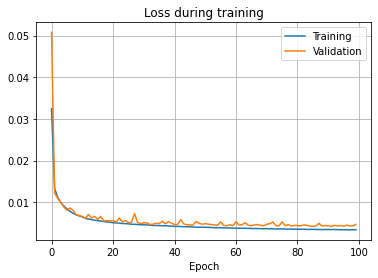

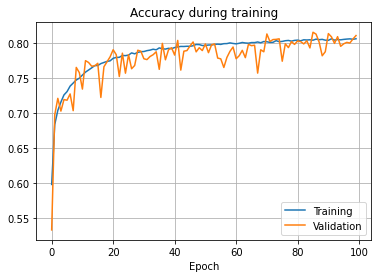

In [22]:
display_history(hist)

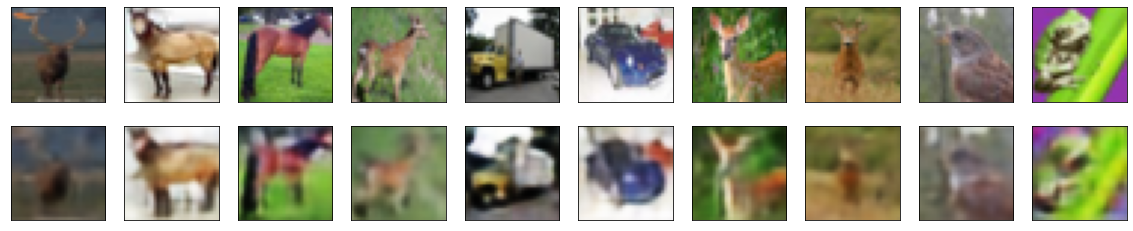

In [25]:
import matplotlib.pyplot as plt

deb_imgs = model.predict(X_test)

n = 10 #no images to plot
imgs = np.random.randint(low=0,high=10000,size=n)
plt.figure(figsize=(20, 4))
for (i,idx) in enumerate(imgs):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(y_test[idx])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(deb_imgs[idx])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [31]:
def build_cnn(input_shape, n_ch, L=3):
    x = layers.Input(shape=input_shape)
    # encoder
    h = x
    for i in range(L):
        h = layers.Conv2D(n_ch, kernel_size=3, strides=1, padding='same')(h)
        h = layers.ReLU()(h)
        
        n_ch = n_ch / 2

    # decoder
    d = h
    for i in range(L):
        d = layers.Conv2DTranspose(n_ch, kernel_size=3, strides=1, padding='same')(d)
        d = layers.ReLU()(d)

        n_ch = n_ch * 2

    f = layers.Conv2DTranspose(3, kernel_size=3, strides=1, padding='same', activation='sigmoid')(d)

    return Model(x, f)

model = build_cnn(img_size, 64)
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 re_lu_23 (ReLU)             (None, 32, 32, 64)        0         
                                                                 
 conv2d_31 (Conv2D)          (None, 32, 32, 32)        18464     
                                                                 
 re_lu_24 (ReLU)             (None, 32, 32, 32)        0         
                                                                 
 conv2d_32 (Conv2D)          (None, 32, 32, 16)        4624      
                                                                 
 re_lu_25 (ReLU)             (None, 32, 32, 16)        0   

In [32]:
model.compile(optimizer="adam", loss=tf.keras.losses.MeanSquaredError(), metrics=['accuracy'])

In [33]:
BATCH_SIZE = 128
N_EPOCHS = 100

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=0.5e-6)

hist = model.fit(X_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=N_EPOCHS,
              validation_split=0.1, callbacks=[lr_reducer])

Epoch 1/100
352/352 [==============================] - 9s 21ms/step - loss: 0.0112 - accuracy: 0.6455 - val_loss: 0.0052 - val_accuracy: 0.7605
Epoch 2/100
352/352 [==============================] - 7s 19ms/step - loss: 0.0048 - accuracy: 0.7938 - val_loss: 0.0044 - val_accuracy: 0.8139
Epoch 3/100
352/352 [==============================] - 7s 19ms/step - loss: 0.0044 - accuracy: 0.8113 - val_loss: 0.0041 - val_accuracy: 0.8188
Epoch 4/100
352/352 [==============================] - 7s 19ms/step - loss: 0.0041 - accuracy: 0.8147 - val_loss: 0.0041 - val_accuracy: 0.8202
Epoch 5/100
352/352 [==============================] - 7s 19ms/step - loss: 0.0039 - accuracy: 0.8203 - val_loss: 0.0038 - val_accuracy: 0.8282
Epoch 6/100
352/352 [==============================] - 7s 21ms/step - loss: 0.0038 - accuracy: 0.8238 - val_loss: 0.0038 - val_accuracy: 0.8240
Epoch 7/100
352/352 [==============================] - 7s 20ms/step - loss: 0.0037 - accuracy: 0.8264 - val_loss: 0.0036 - val_accuracy:

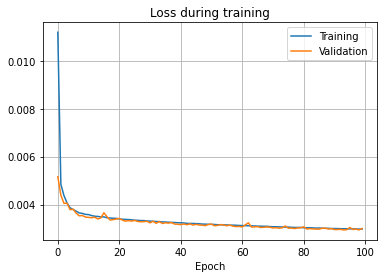

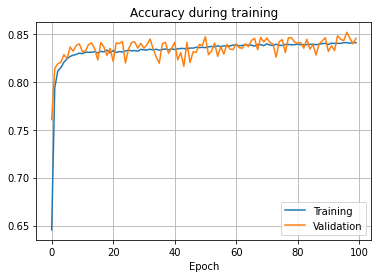

In [34]:
display_history(hist)

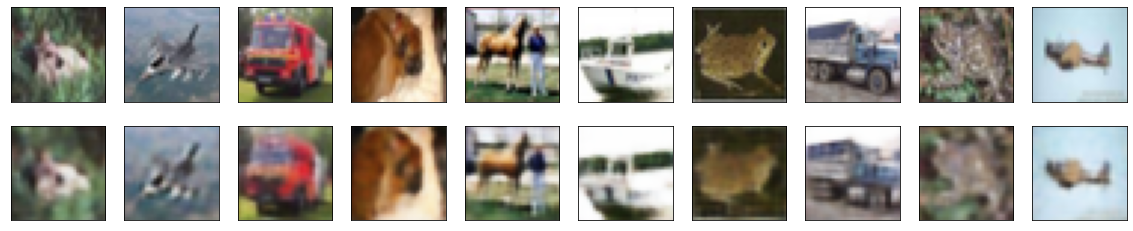

In [35]:
import matplotlib.pyplot as plt

deb_imgs = model.predict(X_test)

n = 10 #no images to plot
imgs = np.random.randint(low=0,high=10000,size=n)
plt.figure(figsize=(20, 4))
for (i,idx) in enumerate(imgs):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(y_test[idx])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(deb_imgs[idx])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
